

## Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. (10 баллов)

6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут. (35 баллов)


### Файлы:

#### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
- customer_unique_id —  уникальный идентификатор пользователя
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя
 
#### olist_orders_dataset.csv —  таблица заказов
- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

#### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

In [2]:
import pandas as pd
import requests
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Timestamp
import numpy as np
from operator import attrgetter
import matplotlib.colors as mcolors
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [3]:
customers = pd.read_csv('/home/jupyter-o-demchenko-18/intermediate_project/olist_customers_dataset.csv')
order_items = pd.read_csv('/home/jupyter-o-demchenko-18/intermediate_project/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
order = pd.read_csv('/home/jupyter-o-demchenko-18/intermediate_project/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [3]:
# соединить таблицу customers(таблица с уникальными идентификаторами пользователей) и таблицу order(таблица заказов) по колонке customer_id (идентификатор пользователя)
one_order = customers[['customer_unique_id', 'customer_id']].merge(order[['order_status', 'customer_id']], on=['customer_id'])


In [4]:
# Отбираем строки, где статус заказа "доставлен"(order_status = delivered). 
# Группируем уникальных пользователей и считаем их кол-во
# Отбираем строки с кол-вом заказов = 1 и считаем кол-во этих строк.
one_order_count = one_order \
    .query("order_status == 'delivered'") \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_status': 'count'}) \
    .rename(columns={'order_status': 'count_one_order'}) \
    .query("count_one_order == '1'") \
    .count()
    

In [5]:
one_order_count

customer_unique_id    90557
count_one_order       90557
dtype: int64

###### ОТВЕТ: 90557 Пользователей совершили покупку один раз

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 
## (5 баллов)

In [6]:
order.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [7]:
# Выделяем номер месяца из даты создания заказа(order_purchase_timestamp) в отдельную колонку 'month'
order['month'] = order.order_purchase_timestamp.dt.month

In [8]:
# замена пропущенных значений в новой колонке 'month' на 0
order['month'].fillna(0, inplace=True)

In [9]:
# Отбираем строки со значением статуса заказов "canceled" и "unavailable"
# Группируем по месяцу и статусу заказа
# Подсчет кол-ва недоставленных заказов по месяцам
# Групируем по статусу заказа и считаем среднее кол-во недоставленных заказов (колонка - 'orders_mean')
not_delivered_orders = order \
    .query('order_status == "canceled" or order_status == "unavailable"') \
    .groupby(['month', 'order_status'], as_index=False) \
    .agg({'customer_id' : 'count'}) \
    .groupby('order_status', as_index=False) \
    .agg({'customer_id': 'mean'}) \
    .round(0) \
    .rename(columns = {'customer_id':'orders_mean'})

print('Ответ: Среднее кол-во недоставленных заказов')

not_delivered_orders

Ответ: Среднее кол-во недоставленных заказов


,order_status,orders_mean
0,canceled,52.0
1,unavailable,51.0


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 
## (5 баллов)

In [10]:
# Вытащим день недели из даты доставки order_estimated_delivery_date
order['day_of_the_week'] = order.order_estimated_delivery_date.dt.day_name()

In [11]:
# Соединим две таблицы (order_items - товарные позиции, входящие в заказы и order - таблица заказов) по ключу 'order_id'
# оставляя необходимые колонки ('product_id', 'day_of_the_week', 'order_status') для дальнейших расчетов
order_day_of_the_week = order_items[['product_id', 'order_id']].merge(order[['order_id', 'day_of_the_week', 'order_status']], on=['order_id'])

In [12]:
# Вид полученной таблицы
order_day_of_the_week.head()

,product_id,order_id,day_of_the_week,order_status
0,4244733e06e7ecb4970a6e2683c13e61,00010242fe8c5a6d1ba2dd792cb16214,Friday,delivered
1,e5f2d52b802189ee658865ca93d83a8f,00018f77f2f0320c557190d7a144bdd3,Monday,delivered
2,c777355d18b72b67abbeef9df44fd0fd,000229ec398224ef6ca0657da4fc703e,Monday,delivered
3,7634da152a4610f1595efa32f14722fc,00024acbcdf0a6daa1e931b038114c75,Monday,delivered
4,ac6c3623068f30de03045865e4e10089,00042b26cf59d7ce69dfabb4e55b4fd9,Friday,delivered


Оставим только УЖЕ ЗАКАЗАННЫЕ товары, т.е. заказы, статус которых:

- processing —  в процессе сборки заказа

- shipped —  отгружен со склада

- delivered —  доставлен пользователю.

Сгруппируем по id продукта и дню недели и посчитаем кол-во сделанных заказов каждого товара для каждого дня недели. Переименуем полученную колонку в 'count_orders'. Отсортируем полученные значения в порядке убывания.

In [13]:
count_orders_day = order_day_of_the_week \
    .query('order_status == "processing" or order_status == "shipped" or order_status == "delivered"') \
    .groupby(['product_id', 'day_of_the_week'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns = {'order_id':'count_orders'}) \
    .sort_values('count_orders', ascending=False)


In [14]:
# Проверим на наличие дубликатов id продуктов
any(count_orders_day['product_id'].duplicated())

True

In [15]:
# Дубликаты присутствуют. Поэтому удалим их
count_orders_day.drop_duplicates('product_id').reset_index(drop=True)

# Итоговая таблица:

,product_id,day_of_the_week,count_orders
0,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,126
1,99a4788cb24856965c36a24e339b6058,Wednesday,117
2,422879e10f46682990de24d770e7f83d,Tuesday,111
3,389d119b48cf3043d311335e499d9c6b,Friday,90
4,368c6c730842d78016ad823897a372db,Thursday,87
...,...,...,...
32609,661a91a30ea8c794b9f0b1797d8832c0,Monday,1
32610,661b9f45d2c7838b67a935446b8a8fd7,Friday,1
32611,661bbdcbe54d141b50aeaf9d33384d34,Wednesday,1
32612,661d83b6b4988942aa9b449b57e12f81,Friday,1


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
## Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.                  
## (8 баллов) 

In [16]:
# проверка наличия дубликатов идентификаторов пользователей
any(customers['customer_id'].duplicated())

False

In [17]:
# получаем кол-во недель по каждому месяцу
order['week_in_month'] = (order.order_delivered_customer_date.dt.daysinmonth / 7).round(4)

In [18]:
# Cоединим две таблицы (order с таблицей заказов и customers с информацией о пользователях по ключу 'customer_id')
orders_in_month = order[['customer_id', 'order_id', 'order_status', 'month', 'week_in_month']].merge(customers[['customer_id', 'customer_unique_id']], on=['customer_id'])

Отберем доставленные заказы (order_status == delivered). Далее группировка по уникательному идентификатору пользователя и месяцу заказа. Подсчитываем кол-во заказов каждого пользователя в месяц. Полученные значения записываются в колонку 'count_orders'. И отсортируем по месяцам.

In [19]:
orders_in_month_uniq = orders_in_month \
    .query('order_status == "delivered"') \
    .groupby(['customer_unique_id', 'month'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns = {'order_id':'count_orders'}) \
    .sort_values('month', ascending=True) \
    .reset_index(drop=True)


In [20]:
# Запишем в колонку 'orders_in_week' кол-во  среднего числа покупок каждого пользователя в каждый месяц. 
# Значения в колонках получены путем деления числа заказов в месяц на кол-во недель в месяце
orders_in_month_uniq['orders_in_week'] = (orders_in_month_uniq.count_orders/orders_in_month.week_in_month).round(4)

In [21]:
# Удаляем пропущенные значения
orders_in_month_uniq.dropna(axis=0)

,customer_unique_id,month,count_orders,orders_in_week
0,82531daaa7ffd6e710d9aa041b64f4fc,1,1,0.2258
1,cc71d0d999365346d1022c0bf3b4b0e3,1,1,0.2258
2,11ddbd9781791a2189f37255546aaf95,1,1,0.2258
3,5b09c620db60411b0be6f1817c6cbe71,1,1,0.2258
4,cc6f81ca4d2992991e860e88dbea4431,1,1,0.2500
...,...,...,...,...
95149,52832e2d43e2afc66377c52f26dacfc4,12,1,0.2258
95150,def6a1bb25ed86d9fc212b52d45162a1,12,1,0.2258
95151,8ee82882d3839ff934a79e7e7c721997,12,1,0.2258
95152,defe4411ce1c0039696a89f179d3fbfa,12,1,0.2500


In [22]:
orders_in_month_uniq.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
month,95155.0,6.034943,3.226352,1.0000,3.0000,6.0000,8.0000,12.0000
count_orders,95155.0,1.013904,0.124318,1.0000,1.0000,1.0000,1.0000,6.0000
orders_in_week,92323.0,0.233022,0.029432,0.2258,0.2258,0.2258,0.2333,1.3548


Вывод: Среднее кол-во заказов в неделю у более 75% пользователей меньше 1.

## 5. Напиши функцию на python, позволяющую строить когортный анализ. 
## В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. 
## (10 баллов)

Retention - это способность компании удерживать своих потребителей в течение определенного периода времени.

CRR(Customer Retention Rate) = (Кол-во клиентов на конец периода-Кол-во новых клиентов за период) \ Кол-во клиентов на начало периода

In [10]:
# Создадим новый df из двух, оставив необходимые колонки для дальнейшего анализа
df = order[['customer_id', 'order_id', 'order_purchase_timestamp']].merge(customers[['customer_id', 'customer_unique_id']], on=['customer_id'])
df.head()

,customer_id,order_id,order_purchase_timestamp,customer_unique_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


In [11]:
# Проверим наличие дубликатов
any(df.duplicated())

False

In [42]:
# Основная информация по df
df.describe().transpose()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,count,unique,top,freq,first,last
customer_id,99441,99441,e052518e07930f3ea59752fe0cdc66a7,1,NaT,NaT
order_id,99441,99441,5b30ad24f4e7ba20015ff2f3c2c30aa5,1,NaT,NaT
order_purchase_timestamp,99441,98875,2018-03-31 15:08:21,3,2016-09-04 21:15:19,2018-10-17 17:30:18
customer_unique_id,99441,96096,8d50f5eadf50201ccdcedfb9e2ac8455,17,NaT,NaT


In [43]:
# Проверка пропущенных значений
df.isna().sum()

customer_id                 0
order_id                    0
order_purchase_timestamp    0
customer_unique_id          0
dtype: int64

In [44]:
# Создадим df с группировкой по уникальному идентификатору пользователя и кол-вом заказов у каждого пользователя
orders = df.groupby(['customer_unique_id'])['order_id'].nunique()
# Посчитаем какое кол-во пользователей совершило более 1 заказа
orders_perc = np.sum(orders > 1) / df['customer_unique_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% покупателей совершили более одного заказа.')

NameError: name 'mult_orders_perc' is not defined

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


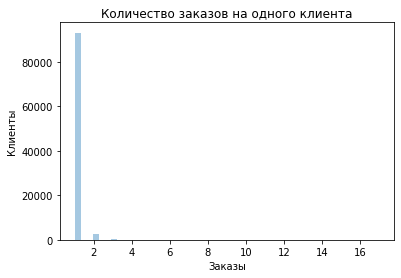

In [45]:
# Посмотрим на графике распределение кол-ва заказов у каждого пользвателя
ax = sns.distplot(orders, kde=False, hist=True)
ax.set(title='Количество заказов на одного клиента',
       xlabel='Заказы', 
       ylabel='Клиенты');

Из графика также хорошо видно, что практически все покупатели совершают менее 1 покупки

In [46]:
# Сохраним df с необходимыми колонками и удалим дубликаты
df = df[['customer_unique_id', 'order_id', 'order_purchase_timestamp']].drop_duplicates()

In [47]:
# Функция для разбиения на когорты по месяцам
def cohort_by_month(df):
    df = df.groupby('customer_unique_id', as_index=False).agg({'order_purchase_timestamp' : 'min'})
    df['Cohort'] = df['order_purchase_timestamp'].dt.strftime('%Y-%m')
        
    return df[['customer_unique_id', 'Cohort']]

In [48]:
cohort_by_month = cohort_by_month(df)
cohort_by_month.head()

,customer_unique_id,Cohort
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [49]:
# Cоединим таблицы с начальными данными (df) c таблицей разбиения когорты по месяцам
df = df.merge(cohort_by_month)

# Оставим из колонки "время создания заказа" год и месяц и переименуем полученную колонку на 'order_period'
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].dt.strftime('%Y-%m')
df.rename(columns={'order_purchase_timestamp': 'order_period'}, inplace=True)
df.head()

,customer_unique_id,order_id,order_period,Cohort
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,69923a4e07ce446644394df37a710286,2017-09,2017-09
2,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07,2018-07
3,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08,2018-08
4,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11,2017-11


In [50]:
# Функция для создания периодов для когорт

def cohort_period(df):
    df['cohort_period'] = np.arange(len(df))
    return df

In [51]:
# Функция для построения когортного анализа

def retention_by_cohort(df):
    # считаем уникальных пользователей и число заказов по когортам и периодам заказов
    cohort_by_month = df.groupby(['Cohort', 'order_period']).agg({'customer_unique_id': 'nunique',
                                                           'order_id': 'nunique'})
    # переименовываем колонки
    cohort_by_month.rename(columns={'customer_unique_id': 'customers',
                            'order_id': 'orders'}, inplace=True)  

    cohort_by_month = cohort_by_month.groupby(level=0).apply(cohort_period)
    
    # реиндексируем датафрейм
    cohort_by_month.reset_index(inplace=True)
    cohort_by_month.set_index(['Cohort', 'cohort_period'], inplace=True)

    # создаем серию, в которую помещаем размер когорт
    cohort_group_size = cohort_by_month['customers'].groupby(level=0).first()
    cohort_group_size.head()

    # считаем retention
    user_retention = cohort_by_month['customers'].unstack(1).divide(cohort_group_size, axis=0)

    return user_retention

In [52]:
retention = retention_by_cohort(df)

In [53]:
color = (user_retention
          .style
          .set_caption('User retention by cohort') # название таблицы
          .background_gradient(cmap='YlOrRd') # цвет ячеек по столбцам
          .highlight_null('white') # белый фон для значений Nan
          .format("{:.2%}", na_rep="") # числа в процентах, NaN заменяем на пустую ячейку
     )
color

NameError: name 'user_retention' is not defined

In [36]:
# Функция для вычесления самого высокого retention

def max_retention(df_name, number_of_month):
    a = (df_name.iloc[:,number_of_month]*100/df_name.iloc[:,0]).idxmax()
    return a

# применение функции для третьего месяца
print('\033[1m''Ответ: Когорта с самым высоким retention на 3-й месяц', max_retention(retention, 3))

Ответ: Когорта с самым высоким retention на 3-й месяц 2017-06


## 6. Построй RFM-кластеры для пользователей. 
## Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). 
## (35 баллов)

#### RFM- это сегментация клиентской базы по трем основным показателям потребительского поведения:


- R - recency — давность (как давно ваши клиенты что-то покупали);

- F - frequency — частота (как часто клиенты покупают);

- M - monetary — деньги (общая сумма покупок).

#### Произведём поочередную сегментацию по каждому показателю и соединим полученные значения в один датафрейм.

In [104]:
# Cоединим все исходные df в один для дальнейшего анализа

dfRFM = (
            order[['customer_id','order_purchase_timestamp', 'order_id']]
            .merge(customers[['customer_id', 'customer_unique_id']])
            .merge(order_items[['order_id', 'price']])
          )
dfRFM.head()

,customer_id,order_purchase_timestamp,order_id,customer_unique_id,price
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,29.99
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,118.70
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,159.90
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,45.00
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,19.90


In [24]:
# Проверка пропущенных значений
dfRFM.isna().sum()

customer_id                 0
order_purchase_timestamp    0
order_id                    0
customer_unique_id          0
price                       0
dtype: int64

In [25]:
# Проверка на наличие дубликатов
any(dfRFM.duplicated())

True

In [26]:
# Удаляем пропущенные значения
df_RFM = dfRFM.drop_duplicates()

In [45]:
# Найдем дату последнего заказа
df_RFM['order_purchase_timestamp'].max()

Timestamp('2018-09-03 09:06:57')

In [33]:
# Проверим наличие цены на отрицательные значения
df_RFM.price.min()

0.85

##### Дата последнего заказа - 2018-09-03. Для расчета давности заказов мы будем использовать дату следующего дня 2018-10-03.

In [39]:
# Запишем в переменную NOW дату от которой будем считать давность покупки
NOW = dt.datetime(2018,10,3)

In [69]:
# Создадим таблицу RFM
rfmTable = df_RFM.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (NOW - x.max()).days, 'order_id': lambda x: len(x), 'price': lambda x: x.sum()})
rfmTable['order_purchase_timestamp'] = rfmTable['order_purchase_timestamp'].astype(int)
rfmTable.rename(columns={'order_purchase_timestamp': 'recency', 
                         'order_id': 'frequency', 
                         'price': 'monetary'}, inplace=True)

In [70]:
rfmTable.sort_values('frequency', ascending=False).head()

,recency,frequency,monetary
customer_unique_id,,,
8d50f5eadf50201ccdcedfb9e2ac8455,43,16,729.62
3e43e6105506432c953e165fb2acf44c,217,10,897.15
ca77025e7201e3b30c44b472ff346268,123,8,723.65
6469f99c1f9dfae7733b25662e7f1782,96,8,639.30
1b6c7548a2a1f9037c1fd3ddfed95f33,230,8,691.21


#### Вывод по таблице:
Например, для клиента ca77025e7201e3b30c44b472ff346268 последний заказ был совершен 123 дня назад, клиент за все время совершил 8 заказов и принес прибыль в 723.65

In [71]:
# Проверим на соответствие исходному датафрейму df_rfm кол-во заказов , совершенных клиентом ca77025e7201e3b30c44b472ff346268
df1 = df_RFM[df_RFM['customer_unique_id'] == 'ca77025e7201e3b30c44b472ff346268']
df1

,customer_id,order_purchase_timestamp,order_id,customer_unique_id,price
5939,dc7dc47999d1b3c4c2f6a085a1a76eef,2018-02-17 01:22:20,9e22fb4a47d29059ef9689ca8b26d8b3,ca77025e7201e3b30c44b472ff346268,49.99
5940,dc7dc47999d1b3c4c2f6a085a1a76eef,2018-02-17 01:22:20,9e22fb4a47d29059ef9689ca8b26d8b3,ca77025e7201e3b30c44b472ff346268,56.99
11395,6ccedfba5919d72fcc8c51bfa982de62,2018-06-01 11:38:29,8dacd1da7c4dc40d5c59e7ddd93b3ac8,ca77025e7201e3b30c44b472ff346268,74.99
28660,71f39c371308d132d7633895477dd307,2018-04-26 11:44:48,d07179898f582cd4b62f9f5328698baf,ca77025e7201e3b30c44b472ff346268,74.99
31151,852e5ea6e9d74416ddf88bdbdb3189b9,2018-05-03 06:11:22,cc9782f02aae34f01d12f3dbee4d5d93,ca77025e7201e3b30c44b472ff346268,10.99
67460,c59e684f832f832056ceee2c310cfc7f,2018-01-25 21:10:57,f3584b023b097595c8e2b0b6fd51a839,ca77025e7201e3b30c44b472ff346268,59.90
92549,b145bff18e79ac4dfb3fb91e61906f38,2018-02-09 15:43:37,c70e1bd940c5723bf066a1dbcc1455e8,ca77025e7201e3b30c44b472ff346268,125.90
97670,fc709ab645b71acd6046aeb03b590aa5,2017-10-09 12:34:39,ee84d18908ccf2b4c57008c552b98d1c,ca77025e7201e3b30c44b472ff346268,269.90


### Сегментирование метрик 

Разделим на кластеры по квартилям. Получим четыре равные группы (квартили) с тремя переменными, которые образуют 64 (4x4x4) клиентских кластера.

In [72]:
# Вычисление квантилей в датафрейме
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [73]:
segmented_rfm = rfmTable

In [74]:
# Функция для разбиения на кластеры для R (recency — давность). 1- самые свежие заказы, 4 - самые старые заказы
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

# Функция для разбиения на кластеры для F(frequency — частота) и M(monetary — деньги). 
# 1- наибольшее число заказов(наибольшая сумма заказов), 4 - наименьшее число заказов(наименьшая сумма заказов)   
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [75]:
# Применение функций для кластеризации
segmented_rfm['R'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['F'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['M'] = segmented_rfm['monetary'].apply(FMScore, args=('monetary',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary,R,F,M
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,145,1,129.90,1,4,2
0000b849f77a49e4a4ce2b2a4ca5be3f,148,1,18.90,1,4,4
0000f46a3911fa3c0805444483337064,571,1,69.00,4,4,3
0000f6ccb0745a6a4b88665a16c9f078,355,1,25.99,3,4,4
0004aac84e0df4da2b147fca70cf8255,322,1,180.00,3,4,1


In [103]:
# Cегментирование(RFMScore) на основании полученных кластеров R F M через функцию map и сложение по строкам str
segmented_rfm['RFMScore'] = segmented_rfm.R.map(str) + segmented_rfm.F.map(str) + segmented_rfm.M.map(str)
segmented_rfm.head()

,recency,frequency,monetary,R,F,M,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,145,1,129.90,1,4,2,142
0000b849f77a49e4a4ce2b2a4ca5be3f,148,1,18.90,1,4,4,144
0000f46a3911fa3c0805444483337064,571,1,69.00,4,4,3,443
0000f6ccb0745a6a4b88665a16c9f078,355,1,25.99,3,4,4,344
0004aac84e0df4da2b147fca70cf8255,322,1,180.00,3,4,1,341


### Расчет средних значений для кластеров

In [110]:
RFM_mean = segmented_rfm.groupby('RFMScore')['frequency', 'monetary', 'recency'].mean().round(0)
RFM_mean

,frequency,monetary,recency
RFMScore,,,
111,2.0,341.0,93.0
112,2.0,115.0,90.0
113,2.0,63.0,93.0
114,2.0,34.0,91.0
141,1.0,342.0,93.0
142,1.0,113.0,92.0
143,1.0,62.0,90.0
144,1.0,28.0,91.0
211,2.0,303.0,202.0
